**1) Implement VAE on Fashion-MNIST dataset using PyTorch**

Design choice and justification are included in the comments

In [ ]:
#import the necessary libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load FashionMNIST dataset into train and test
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='.', train=False, download=True, transform=transform)

# Use PyTorch DataLoader to create iterable datasets
b_size=2048
print(len(train_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=b_size, shuffle=False)

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        # Creating an Encoder Network
        self.encoder = nn.Sequential(nn.Linear(input_size, hidden_size),
            #In the encoder network of the VAE, ReLU is used as the activation function for the hidden layer. ReLU can improve the training speed 
            #and the generalization performance of the model by introducing non-linearity and helping to prevent the vanishing gradient problem.
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size * 2)
        )
        self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size),
            #In the decoder network of the VAE, ReLU is used as the activation function for the hidden layer. ReLU can improve the training speed and the
            # generalization performance of the model by introducing non-linearity and helping the model to learn more complex representations of the data.
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            #The sigmoid function is used in the decoder network as the activation function for the output layer. The sigmoid function maps the output of 
            #the linear layer to the range of [0, 1], which is suitable for modeling probability values.
            #In the case of image generation, the output of the VAE represents the probability of each pixel (or, equivalently, the intensity 
            #of each pixel). By using the sigmoid function as the activation function for the output layer, the VAE is able to model the probability 
            #of each pixel in a continuous and bounded manner.
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode the input recieved
        x = self.encoder(x)
        # Split the encoding into mean and log of variance
        # Here the covariance matrix can be considered as a diagonal matrix due to which the encoding can be split with equal size for mean and log of variance
        mu, log_var = x[:, :self.latent_size], x[:, self.latent_size:]
        # Sampling latent representation

        #By definition, the standard deviation (sigma) must be a positive real number. A common approach to enforce this is to use the ReLU function
        #to obtain the value of sigma, but this can lead to poorly defined gradients around zero. In addition, sigma values are usually very small 
        #(1 >> sigma > 0), which can introduce numerical instabilities when working with floating point arithmetic.

        #Using the log transform maps the numerically unstable range of very small numbers in the interval [1, 0] to the interval [log(1), -infinity], 
        #where there is more space available to work with. Calculating the log and exp functions are numerically stable and easy, 
        #so this can help to reduce the risk of numerical instabilities. In VAEs, the log(sigma) value is also needed in the Kullback-Leibler divergence 
        #term, so it must be calculated anyways.

        std = torch.exp(0.5*log_var)

        #In its original form, a VAE samples from a random node 𝑧 that is approximated by the parametric model 𝑞(𝑧∣𝜙,𝑥) of the true posterior. However, 
        #the backpropagation algorithm cannot flow through a random node.To address this issue, we can introduce a new parameter 𝜖 and reparameterize 𝑧 in 
        #a way that allows backpropagation to flow through the deterministic nodes. By assuming that 𝜖 ~ N(0,1), the randomness of 𝑧 only stems from 𝜖 for 
        #a given 𝑥. This way, the dependency between 𝑧 and 𝑥 is deterministic and differentiable.
        eps = torch.randn_like(std)
        #similar to scaling
        z = mu + std*eps

        # Decoding latent representation
        x = self.decoder(z)
        return x, mu, log_var

    # Defining loss function
def vae_loss(x, x_recon, mu, log_var):
    # ∥x_cap −x∥^2 
    squared_loss = F.mse_loss(x_recon, x, reduction='sum')
    # KL divergence loss formula after simplification (Proof: https://ai.stackexchange.com/a/26400)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())
    # Add both and return total loss
    return squared_loss + kl_loss

# Define model and move to device. We can also define the hyperparameters for the model, such as the input size, hidden size, and latent size
model = VAE(input_size=28*28, hidden_size=512, latent_size=2).to(device)

# Define optimizer, learning rate is an optional parameter here

#Adam is a popular choice for optimizing deep learning models due to its fast convergence and good performance in a wide range of tasks. Adam is an 
#extension of the stochastic gradient descent (SGD) optimization algorithm that utilizes moving averages of the parameters to provide a running estimate 
#of the second raw moments of the gradients. This allows Adam to adapt the learning rates of each parameter based on the historical gradient information, 
#which can help to improve the convergence rate and the generalization performance of the model.

optimizer = optim.Adam(model.parameters())

# Train model and loop over the epochs
for epoch in range(20):
    # Loop over the batches
    for i, (x, y) in enumerate(train_loader):
        # Flatten the images and move data to device 
        x = x.to(device).view(-1, 28*28)
        y = y.to(device)
        # Forward pass
        x_cap, mu, log_var = model(x)
        # Compute the loss
        loss = vae_loss(x, x_cap, mu, log_var)/b_size
        #Zero the gradients
        optimizer.zero_grad()
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/20], Loss: {loss.item():.4f}')    

60000
Epoch [1/20], Loss: 14.0313
Epoch [2/20], Loss: 11.6307
Epoch [3/20], Loss: 10.8755
Epoch [4/20], Loss: 10.2846
Epoch [5/20], Loss: 10.1099
Epoch [6/20], Loss: 9.9829
Epoch [7/20], Loss: 9.7122
Epoch [8/20], Loss: 9.4498
Epoch [9/20], Loss: 9.3044
Epoch [10/20], Loss: 10.0118
Epoch [11/20], Loss: 9.3725
Epoch [12/20], Loss: 9.3777
Epoch [13/20], Loss: 9.5086
Epoch [14/20], Loss: 9.2316
Epoch [15/20], Loss: 9.4191
Epoch [16/20], Loss: 9.0475
Epoch [17/20], Loss: 9.2397
Epoch [18/20], Loss: 9.0034
Epoch [19/20], Loss: 9.1648
Epoch [20/20], Loss: 8.9744


**Visualization**

Display randomly generated images (create a 2D grid of latent variables z and plot the generated image
of each z) 

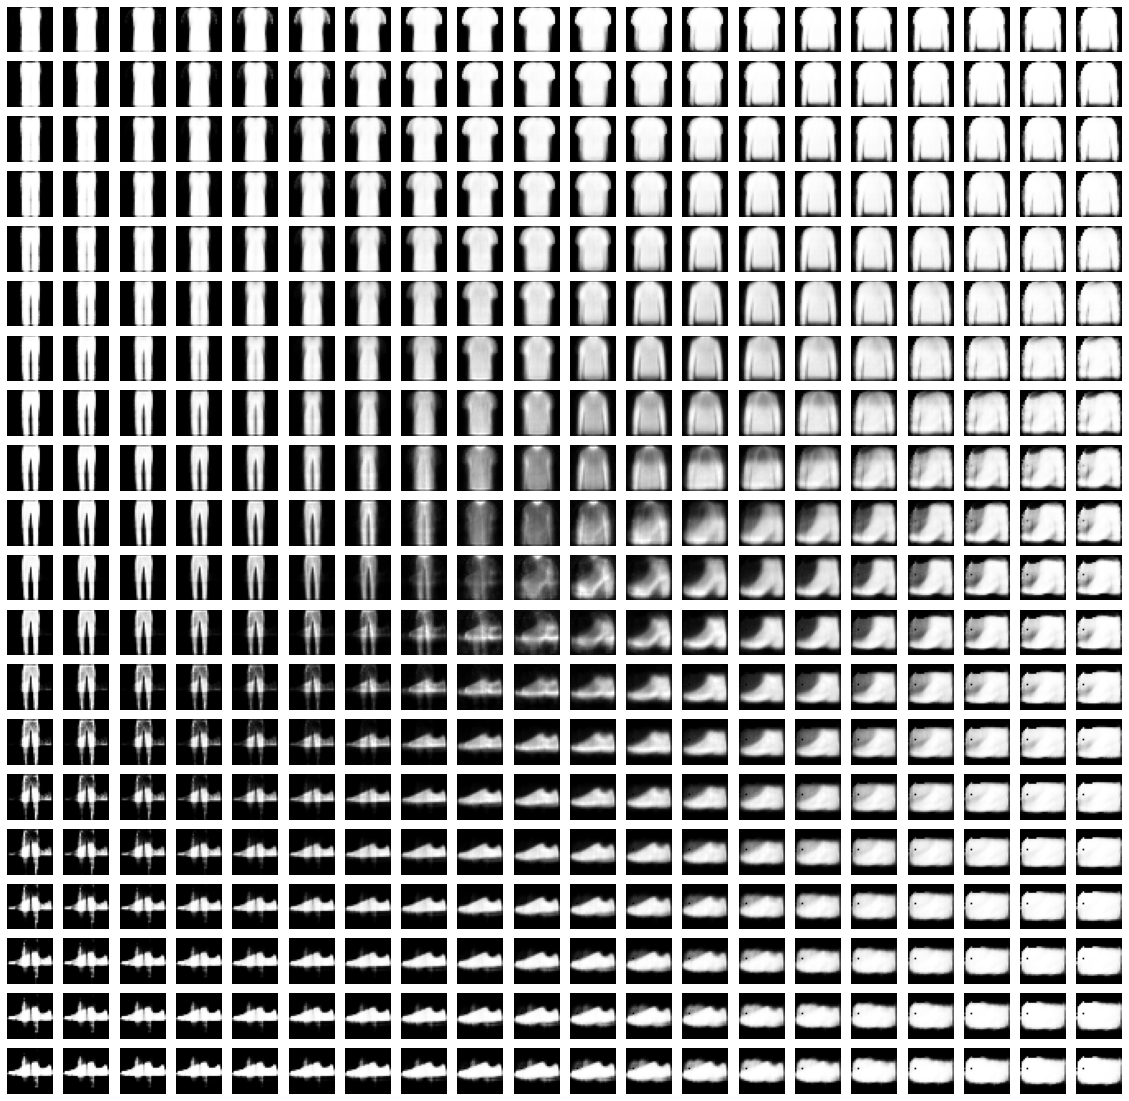

In [ ]:
import matplotlib.pyplot as plt

# Generate a 2D grid of latent variables
z1 = torch.linspace(-4, 4, 20).to(device)
z2 = torch.linspace(-4, 4, 20).to(device)
z1, z2 = torch.meshgrid(z1, z2)
# choose any two coordinates for this visualization purpose. We can also do something like PCA to choose non-standard directions 
#to explore if latent_dim is not equal to 2
z = torch.cat((z1.reshape(-1, 1), z2.reshape(-1, 1)), dim=1)

# Generate images by passing the latent variables through the trained decoder
reconstructed_images = model.decoder(z).detach().cpu()

# Plot the generated images
fig, axs = plt.subplots(20, 20, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

# Show the plot    
plt.show()


**Interpretation of the generated Fashion-MNIST images**

We can see how the image changes as we move in different directions in the latent dimension, resulting in transformations such as a T-shirt turning into a Pullover, a Trouser turning into a T-shirt, a Trouser turning into a Sneaker, a Pullover turning into a Sandal, and a Sneaker turning into an Ankle Boot. This is just a small defined area we have chosen; similar transformations can be observed for any coordinates in the latent space. The VAE appears to generate a smoother hidden space with cleaner transitions between fashion items.

I chose a very low value for the latent dimension (2 for Fashion-MNIST) in the above. It is possible that using a higher dimensional latent space could lead to a model that better fits the training set. The generated images are somewhat blurry, but they capture the global organization of pixels needed to represent samples from the 10 fashion item categories. The spatial structure has been learned and is present only in the decoder weights. It is important to note that the VAE is an unsupervised model, meaning it did not use any label information during training. However, we can see that the 2D latent space is largely structured around the categories of images in the training set.

**2) Implement VAE on CIFAR10 datasets using PyTorch**

Design choice and justification are included in the comments

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#To Convert CIFAR10 into Grayscale image so that the above code for Fashion-MNIST can be reused here
grayscale_transform = transforms.Grayscale(num_output_channels=1)
transform = transforms.Compose([grayscale_transform, transforms.ToTensor()])

# Load CIFAR10 dataset into train and test
train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

# Use PyTorch DataLoader to create iterable datasets
#print(len(train_dataset))
b_size=2048
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=b_size, shuffle=False)

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        # Creating an Encoder Network
        self.encoder = nn.Sequential(nn.Linear(input_size, hidden_size),
            #In the encoder network of the VAE, ReLU is used as the activation function for the hidden layer. ReLU can improve the training speed 
            #and the generalization performance of the model by introducing non-linearity and helping to prevent the vanishing gradient problem.                         
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size * 2)
        )
        self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size),
            #In the decoder network of the VAE, ReLU is used as the activation function for the hidden layer. ReLU can improve the training speed and the
            # generalization performance of the model by introducing non-linearity and helping the model to learn more complex representations of the data.                         
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            #The sigmoid function is used in the decoder network as the activation function for the output layer. The sigmoid function maps the output of 
            #the linear layer to the range of [0, 1], which is suitable for modeling probability values.
            #In the case of image generation, the output of the VAE represents the probability of each pixel (or, equivalently, the intensity 
            #of each pixel). By using the sigmoid function as the activation function for the output layer, the VAE is able to model the probability 
            #of each pixel in a continuous and bounded manner.
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode the input recieved
        x = self.encoder(x)
        # Split the encoding into mean and log of variance
        # Here the covariance matrix can be considered as a diagonal matrix due to which the encoding can be split with equal size for mean and log of variance
        mu, log_var = x[:, :self.latent_size], x[:, self.latent_size:]
        # Sampling latent representation

        #By definition, the standard deviation (sigma) must be a positive real number. A common approach to enforce this is to use the ReLU function
        #to obtain the value of sigma, but this can lead to poorly defined gradients around zero. In addition, sigma values are usually very small 
        #(1 >> sigma > 0), which can introduce numerical instabilities when working with floating point arithmetic.

        #Using the log transform maps the numerically unstable range of very small numbers in the interval [1, 0] to the interval [log(1), -infinity], 
        #where there is more space available to work with. Calculating the log and exp functions are numerically stable and easy, 
        #so this can help to reduce the risk of numerical instabilities. In VAEs, the log(sigma) value is also needed in the Kullback-Leibler divergence 
        #term, so it must be calculated anyways.

        std = torch.exp(0.5*log_var)

        #In its original form, a VAE samples from a random node 𝑧 that is approximated by the parametric model 𝑞(𝑧∣𝜙,𝑥) of the true posterior. However, 
        #the backpropagation algorithm cannot flow through a random node.To address this issue, we can introduce a new parameter 𝜖 and reparameterize 𝑧 in 
        #a way that allows backpropagation to flow through the deterministic nodes. By assuming that 𝜖 ~ N(0,1), the randomness of 𝑧 only stems from 𝜖 for 
        #a given 𝑥. This way, the dependency between 𝑧 and 𝑥 is deterministic and differentiable.

        eps = torch.randn_like(std)
        #similar to scaling
        z = mu + std*eps
        # Decoding latent representation
        x = self.decoder(z)
        return x, mu, log_var

    # Define loss function
def vae_loss(x, x_recon, mu, log_var):
    # ∥x_cap −x∥^2 
    squared_loss = F.mse_loss(x_recon, x, reduction='sum')
    # KL divergence loss formula after simplification (Proof: https://ai.stackexchange.com/a/26400)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())
    # Add both and return total loss
    return squared_loss + kl_loss

# Define model and move to device. We can also define the hyperparameters for the model, such as the input size, hidden size, and latent size
model = VAE(input_size=32*32, hidden_size=512, latent_size=16).to(device)

# Define optimizer, learning rate is an optional parameter here

#Adam is a popular choice for optimizing deep learning models due to its fast convergence and good performance in a wide range of tasks. Adam is an 
#extension of the stochastic gradient descent (SGD) optimization algorithm that utilizes moving averages of the parameters to provide a running estimate 
#of the second raw moments of the gradients. This allows Adam to adapt the learning rates of each parameter based on the historical gradient information, 
#which can help to improve the convergence rate and the generalization performance of the model.
optimizer = optim.Adam(model.parameters(),lr=0.01)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Train model and loop over the epochs
for epoch in range(30):
    # Loop over the batches
    for i, (x, y) in enumerate(train_loader):
        # Move data to device
        #x = x.to(device).view(-1, 28*28)
        x=torch.squeeze(x)
        #print(x.shape)
        x = x.to(device).view(-1, 32*32)
        y = y.to(device)
        # Forward pass
        x_recon, mu, log_var = model(x)
        # Compute loss
        loss = vae_loss(x, x_recon, mu, log_var)/b_size
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/30], Loss: {loss.item():.4f}')    

Epoch [1/30], Loss: 20.9364
Epoch [2/30], Loss: 18.6749
Epoch [3/30], Loss: 18.1947
Epoch [4/30], Loss: 17.3083
Epoch [5/30], Loss: 16.4934
Epoch [6/30], Loss: 16.2226
Epoch [7/30], Loss: 15.9095
Epoch [8/30], Loss: 16.1263
Epoch [9/30], Loss: 15.4002
Epoch [10/30], Loss: 15.2496
Epoch [11/30], Loss: 15.0734
Epoch [12/30], Loss: 15.1117
Epoch [13/30], Loss: 15.0686
Epoch [14/30], Loss: 14.8878
Epoch [15/30], Loss: 14.6587
Epoch [16/30], Loss: 14.6014
Epoch [17/30], Loss: 14.5966
Epoch [18/30], Loss: 14.5871
Epoch [19/30], Loss: 14.6906
Epoch [20/30], Loss: 14.8550
Epoch [21/30], Loss: 14.2122
Epoch [22/30], Loss: 14.5012
Epoch [23/30], Loss: 14.8708
Epoch [24/30], Loss: 14.3717
Epoch [25/30], Loss: 14.2486
Epoch [26/30], Loss: 14.1553
Epoch [27/30], Loss: 14.7942
Epoch [28/30], Loss: 14.6930
Epoch [29/30], Loss: 14.3248
Epoch [30/30], Loss: 14.3854


**Visualization**

Display randomly generated images (create a 2D grid of latent variables z and plot the generated image of each z)

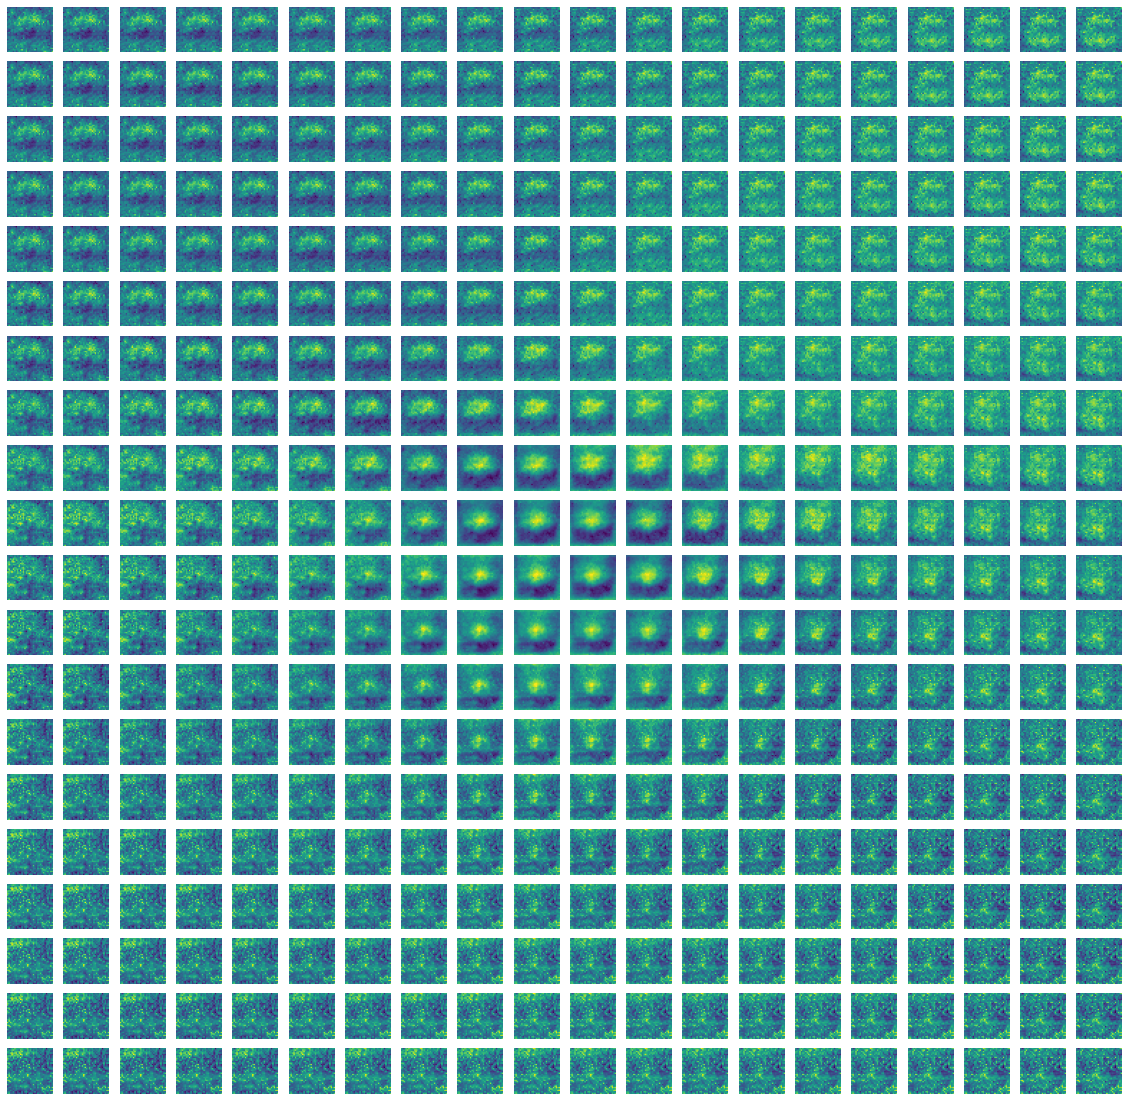

In [ ]:
# Plot grid of generated images
import matplotlib.pyplot as plt

z1, z2 = torch.meshgrid(torch.linspace(-20, 20, 20), torch.linspace(-20, 20, 20))
# choose any two coordinates for this visualization purpose. We can also do something like PCA to choose non-standard directions 
#to explore.
z = torch.cat([z1.reshape(-1, 1), z2.reshape(-1, 1)
,torch.zeros_like(z1).reshape(-1, 1),torch.zeros_like(z2).reshape(-1, 1)
,torch.zeros_like(z1).reshape(-1, 1),torch.zeros_like(z2).reshape(-1, 1)
,torch.zeros_like(z1).reshape(-1, 1),torch.zeros_like(z2).reshape(-1, 1)
,torch.zeros_like(z1).reshape(-1, 1),torch.zeros_like(z2).reshape(-1, 1)
,torch.zeros_like(z1).reshape(-1, 1),torch.zeros_like(z2).reshape(-1, 1)
,torch.zeros_like(z1).reshape(-1, 1),torch.zeros_like(z2).reshape(-1, 1)
,torch.zeros_like(z1).reshape(-1, 1),torch.zeros_like(z2).reshape(-1, 1)], dim=1)

# Generate images by passing the latent variables through the trained decoder
generated_images = model.decoder(z)

# Plot the generated images
fig, axs = plt.subplots(20, 20, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(generated_images[i].detach().numpy().reshape(32, 32))
    ax.axis('off')
plt.show()


**Interpretation of the generated CIFAR-10 images**

I have found that VAEs can achieve good results on simple datasets such as MNIST and FashionMNIST. However, it is more challenging to generate high-quality results on more complex datasets like CIFAR10. In this context, "good results" refer to latent representations that can be obtained by sampling from the latent unit-gaussian and reconstructing the samples vector through the decoding phase. In the case of the CIFAR10 dataset, the loss function did not decrease significantly compared to the loss on the Fashion-MNIST dataset. However, we can still see some variations in the images in the above visualization, such as changes as we move from the center to the outer regions of the latent space.

To generate crisper images that are more similar to the CIFAR10 dataset, it may be necessary to use more complex models like convolutional neural networks (CNNs) in the design of the VAE. Alternatively, we could build a small supervised model on top of the latent representation defined by our encoder to make the model semi-supervised.